<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# Capítulo 4: Implementando um modelo GPT do zero para gerar texto

In [3]:
from importlib.metadata import version

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.10.0
torch version: 2.5.1+cu124
tiktoken version: 0.9.0


- Neste capítulo, implementamos uma arquitetura de LLM semelhante ao GPT; o próximo capítulo se concentrará no treinamento deste LLM.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/01.webp" width="500px">

## 4.1 Codificando uma arquitetura de LLM

- O Capítulo 1 discutiu modelos como GPT e Llama, que geram palavras sequencialmente e são baseados na parte decodificadora da arquitetura original dos transformers.  
- Portanto, esses LLMs são frequentemente chamados de LLMs "semelhantes ao decodificador".  
- Comparado com modelos convencionais de aprendizado profundo, os LLMs são maiores, principalmente devido ao seu vasto número de parâmetros, não à quantidade de código.  
- Veremos que muitos elementos se repetem na arquitetura de um LLM.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/02.webp" width="400px">

- Nos capítulos anteriores, usamos dimensões pequenas de embedding para os tokens de entrada e saída para facilitar a ilustração, garantindo que eles coubessem em uma única página.  
- Neste capítulo, consideramos tamanhos de embedding e modelo semelhantes a um modelo pequeno do GPT-2.  
- Codificaremos especificamente a arquitetura do menor modelo GPT-2 (124 milhões de parâmetros), conforme descrito no artigo de Radford et al., [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) (observe que o relatório inicial menciona 117 milhões de parâmetros, mas isso foi posteriormente corrigido no repositório de pesos do modelo).  
- O Capítulo 6 mostrará como carregar pesos pré-treinados em nossa implementação, que será compatível com tamanhos de modelos de 345, 762 e 1542 milhões de parâmetros.

- Os detalhes de configuração para o modelo GPT-2 de 124 milhões de parâmetros incluem:

In [4]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Tamanho do vocabulário
    "context_length": 1024, # Tamanho do contexto
    "emb_dim": 768,         # Dimensão do Embedding
    "n_heads": 12,          # Número de attention heads
    "n_layers": 12,         # Context length camadas
    "drop_rate": 0.1,       # Taxa de Dropout
    "qkv_bias": False       # Query-Key-Value bias
}

- Usamos nomes de variáveis curtas para evitar linhas de código longas posteriormente.  
- `"vocab_size"` indica um tamanho de vocabulário de 50.257 palavras, suportado pelo tokenizador BPE discutido no Capítulo 2.  
- `"context_length"` representa o número máximo de tokens de entrada do modelo, conforme habilitado pelos embeddings posicionais abordados no Capítulo 2.  
- `"emb_dim"` é o tamanho do embedding para os tokens de entrada, convertendo cada token de entrada em um vetor de 768 dimensões.  
- `"n_heads"` é o número de cabeças de atenção no mecanismo de atenção multi-cabeça implementado no Capítulo 3.  
- `"n_layers"` é o número de blocos transformer dentro do modelo, que implementaremos nas próximas seções.  
- `"drop_rate"` é a intensidade do mecanismo de dropout, discutido no Capítulo 3; 0.1 significa descartar 10% das unidades ocultas durante o treinamento para mitigar o overfitting.  
- `"qkv_bias"` decide se as camadas `Linear` no mecanismo de atenção multi-cabeça (do Capítulo 3) devem incluir um vetor de viés ao calcular os tensores de consulta (Q), chave (K) e valor (V); desabilitaremos essa opção, o que é uma prática padrão em LLMs modernos; no entanto, revisitaremos isso mais tarde ao carregar os pesos pré-treinados do GPT-2 da OpenAI para nossa reimplementação no Capítulo 5.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/03.webp" width="500px">

In [5]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/04.webp?123" width="500px">

In [6]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [7]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


---

Note

- Se você estiver executando este código no Windows ou Linux, os valores resultantes acima podem parecer como segue:
    
```
Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)
```

- Como esses são apenas números aleatórios, isso não é motivo de preocupação, e você pode continuar com o restante do capítulo sem problemas.  
- Uma possível razão para essa discrepância é o comportamento diferente do `nn.Dropout` entre os sistemas operacionais, dependendo de como o PyTorch foi compilado, conforme discutido [aqui no rastreador de problemas do PyTorch](https://github.com/pytorch/pytorch/issues/121595).

---

## 4.2 Normalizando ativações com normalização de camada (Layer Normalization)

- A normalização de camada, também conhecida como LayerNorm ([Ba et al. 2016](https://arxiv.org/abs/1607.06450)), centraliza as ativações de uma camada de rede neural em torno de uma média de 0 e normaliza sua variância para 1.  
- Isso estabiliza o treinamento e permite uma convergência mais rápida para pesos eficazes.  
- A normalização de camada é aplicada tanto antes quanto depois do módulo de atenção multi-cabeça dentro do bloco transformer, que implementaremos mais tarde; ela também é aplicada antes da camada de saída final.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/05.webp" width="400px">

- Vamos ver como a normalização de camada funciona passando uma amostra de entrada pequena por uma camada simples de rede neural:

In [8]:
torch.manual_seed(123)

# Crie 2 exemplos de treinamento com 5 dimensões (características) cada.
batch_example = torch.randn(2, 5)

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


- Vamos calcular a média e a variância para cada um dos 2 inputs acima:

In [9]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Média:\n", mean)
print("Variancia:\n", var)

Média:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variancia:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- A normalização é aplicada a cada um dos dois inputs (linhas) de forma independente; usar `dim=-1` aplica o cálculo na última dimensão (neste caso, a dimensão das características) em vez da dimensão das linhas.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/06.webp" width="400px">

- Subtrair a média e dividir pela raiz quadrada da variância (desvio padrão) centraliza os inputs para ter uma média de 0 e uma variância de 1 ao longo da dimensão da coluna (características).

In [10]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- Cada entrada é centralizada em 0 e tem uma variância unitária de 1; para melhorar a legibilidade, podemos desativar a notação científica do PyTorch.

In [11]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- Cada entrada é centralizada em 0 e tem uma variância unitária de 1; para melhorar a legibilidade, podemos desativar a notação científica do PyTorch.

In [12]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

**Escala e deslocamento**

- Observe que, além de realizar a normalização subtraindo a média e dividindo pela variância, adicionamos dois parâmetros treináveis: um parâmetro de **escala** e um parâmetro de **deslocamento**.  
- Os valores iniciais de **escala** (multiplicando por 1) e **deslocamento** (adicionando 0) não têm efeito; no entanto, **escala** e **deslocamento** são parâmetros treináveis que o LLM ajusta automaticamente durante o treinamento, se for determinado que isso melhoraria o desempenho do modelo na tarefa de treinamento.  
- Isso permite que o modelo aprenda o dimensionamento e o deslocamento apropriados que melhor se adequem aos dados que está processando.  
- Observe também que adicionamos um valor menor (`eps`) antes de calcular a raiz quadrada da variância; isso é para evitar erros de divisão por zero caso a variância seja 0.

**Variância enviesada**  
- No cálculo da variância acima, configurar `unbiased=False` significa usar a fórmula $\frac{\sum_i (x_i - \bar{x})^2}{n}$ para calcular a variância, onde \( n \) é o tamanho da amostra (aqui, o número de características ou colunas); essa fórmula não inclui a correção de Bessel (que usa `n-1` no denominador), fornecendo assim uma estimativa enviesada da variância.  
- Para LLMs, onde a dimensão de embedding `n` é muito grande, a diferença entre usar \( n \) e \( n-1 \) é negligível.  
- No entanto, o GPT-2 foi treinado com uma variância enviesada nas camadas de normalização, razão pela qual também adotamos essa configuração por questões de compatibilidade com os pesos pré-treinados que carregaremos nos capítulos posteriores.

- Vamos agora testar o `LayerNorm` na prática:

In [13]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [14]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/07.webp" width="400px">

## 4.3 Implementando uma rede feedforward com ativações GELU

- Nesta seção, implementaremos um pequeno submódulo de rede neural que é utilizado como parte do bloco transformer em LLMs.  
- Começamos com a função de ativação.  
- No aprendizado profundo, as funções de ativação ReLU (Rectified Linear Unit) são comumente usadas devido à sua simplicidade e eficácia em várias arquiteturas de redes neurais.  
- Em LLMs, vários outros tipos de funções de ativação são usados além da tradicional ReLU; dois exemplos notáveis são GELU (Gaussian Error Linear Unit) e SwiGLU (Swish-Gated Linear Unit).  
- GELU e SwiGLU são funções de ativação mais complexas e suaves, incorporando unidades lineares com base em Gaussiana e sigmoide, respectivamente, oferecendo um desempenho melhor para modelos de aprendizado profundo, ao contrário da função linear simples e segmentada da ReLU.

- GELU (Hendrycks e Gimpel 2016) pode ser implementado de várias maneiras; a versão exata é definida como GELU(x)=x⋅Φ(x), onde Φ(x) é a função de distribuição acumulada da distribuição Gaussiana padrão.
Na prática, é comum implementar uma aproximação computacionalmente mais barata: approximation: $\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)
$ (O modelo original do GPT-2 também foi treinado com essa aproximação).

In [15]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

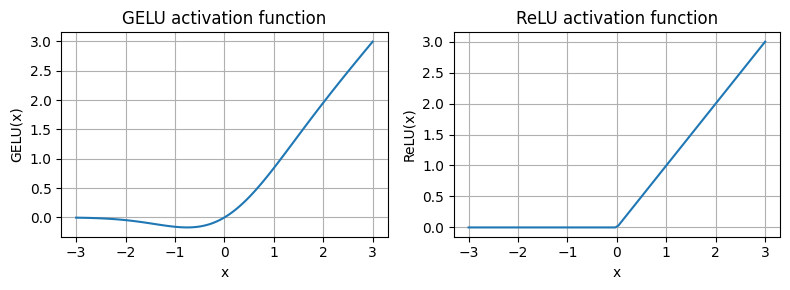

In [16]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

- Como podemos ver, a ReLU é uma função linear segmentada que retorna o valor de entrada diretamente se ele for positivo; caso contrário, ela retorna zero.  
- A GELU é uma função suave e não linear que aproxima a ReLU, mas com um gradiente não zero para valores negativos (exceto aproximadamente em -0,75).  

- Em seguida, vamos implementar o pequeno módulo de rede neural, `FeedForward`, que usaremos mais tarde no bloco transformer do LLM:

In [17]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [18]:
print(GPT_CONFIG_124M["emb_dim"])

768


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/09.webp?12" width="400px">

In [19]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/10.webp" width="400px">

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/11.webp" width="400px">

## 4.4 Adicionando shortcut connections

- Em seguida, vamos falar sobre o conceito por trás das conexões de atalho, também chamadas de conexões de salto ou residuais.  
- Originalmente, as conexões de atalho foram propostas em redes profundas para visão computacional (redes residuais) para mitigar problemas de gradiente que desaparece.  
- Uma conexão de atalho cria um caminho alternativo mais curto para o gradiente fluir pela rede.  
- Isso é alcançado adicionando a saída de uma camada à saída de uma camada posterior, geralmente pulando uma ou mais camadas no meio.  
- Vamos ilustrar essa ideia com uma pequena rede de exemplo:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/12.webp?123" width="400px">

- No código, isso se parece com o seguinte:

In [20]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Calcule a saída da camada atual.
            layer_output = layer(x)
            # Verifique se a conexão de atalho pode ser aplicada.
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calcule a perda com base na proximidade entre o alvo e a saída.
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward pass para calcular os gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Imprima o gradiente absoluto médio dos pesos.
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

- Vamos imprimir os valores do gradiente primeiro **sem** conexões de atalho:

In [ ]:
layer_sizes = [3, 3, 3, 3, 3, 1]

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152039906941354
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


- Em seguida, vamos imprimir os valores do gradiente **com** conexões de atalho:

In [ ]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


- Como podemos ver com base na saída acima, as conexões de atalho evitam que os gradientes desapareçam nas camadas iniciais (em direção a `layer.0`).  
- Usaremos esse conceito de conexão de atalho a seguir, quando implementarmos um bloco transformer.

## 4.5 Conectando camadas de atenção e camadas lineares em um bloco transformer

- Nesta seção, agora combinamos os conceitos anteriores em um chamado **bloco transformer**.  
- Um bloco transformer combina o módulo de atenção multi-cabeça causal do capítulo anterior com as camadas lineares, a rede neural feedforward que implementamos em uma seção anterior.  
- Além disso, o bloco transformer também usa dropout e conexões de atalho.

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import sys
import os

mydrive = "/content/drive/MyDrive/Colab Drive/llm"
mysrc = os.path.join(mydrive, "src/LLMs-from-scratch-main/ch04/01_main-chapter-code")
sys.path.append(mysrc)

In [25]:
from previous_chapters import MultiHeadAttention


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Conexão de atalho para o bloco de atenção
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Formato [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Adicione a entrada original de volta..

        # Conexão de atalho para o bloco feedforward.
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Adicione a entrada original de volta.

        return x

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/13.webp?1" width="400px">

- Suponha que temos 2 amostras de entrada com 6 tokens cada, onde cada token é um vetor de embedding de 768 dimensões; então, este bloco transformer aplica autoatenção, seguido por camadas lineares, para produzir uma saída de tamanho semelhante.  
- Você pode pensar na saída como uma versão aumentada dos vetores de contexto que discutimos no capítulo anterior.

In [26]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Formato: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/14.webp?1" width="400px">

## 4.6 Codificando o modelo GPT

- Estamos quase lá: agora vamos conectar o bloco transformer na arquitetura que codificamos no início deste capítulo, para que possamos obter uma arquitetura GPT utilizável.  
- Observe que o bloco transformer é repetido várias vezes; no caso do modelo GPT-2 menor de 124M, o repetimos 12 vezes.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/15.webp" width="400px">

- A implementação do código correspondente, onde `cfg["n_layers"] = 12`:

In [28]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

- Usando a configuração do modelo de 124 milhões de parâmetros, agora podemos instanciar este modelo GPT com pesos iniciais aleatórios da seguinte forma:

In [29]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


- Treinaremos este modelo no próximo capítulo.  
- No entanto, uma breve observação sobre seu tamanho: anteriormente, nos referimos a ele como um modelo de 124 milhões de parâmetros; podemos verificar esse número da seguinte forma:

In [30]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Número total de parâmetros: {total_params:,}")

Número total de parâmetros: 163,009,536


- Como vemos acima, este modelo tem 163 milhões de parâmetros, não 124 milhões; por quê?  
- No artigo original do GPT-2, os pesquisadores aplicaram **peso compartilhado** (weight tying), o que significa que reutilizaram a camada de embedding de tokens (`tok_emb`) como a camada de saída, ou seja, configuraram `self.out_head.weight = self.tok_emb.weight`.  
- A camada de embedding de tokens projeta os tokens de entrada codificados em one-hot, de dimensão 50.257, para uma representação de embedding de 768 dimensões.  
- A camada de saída projeta os embeddings de 768 dimensões de volta para uma representação de 50.257 dimensões, para que possamos converter essas representações de volta em palavras (mais sobre isso na próxima seção).  
- Assim, a camada de embedding e a camada de saída têm o mesmo número de parâmetros de peso, como podemos ver com base na forma de suas matrizes de peso.  
- No entanto, uma breve observação sobre seu tamanho: anteriormente, nos referimos a ele como um modelo de 124 milhões de parâmetros; podemos verificar esse número da seguinte forma:

In [31]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


- No artigo original do GPT-2, os pesquisadores reutilizaram a matriz de embedding de tokens como uma matriz de saída.  
- Correspondentemente, se subtrássemos o número de parâmetros da camada de saída, obteríamos um modelo de 124 milhões de parâmetros:

In [32]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Número de parâmetros treináveis considerando o compartilhamento de pesos (weight tying).: {total_params_gpt2:,}")

Número de parâmetros treináveis considerando o compartilhamento de pesos (weight tying).: 124,412,160


- Na prática, achei mais fácil treinar o modelo sem o compartilhamento de pesos, por isso não o implementamos aqui.  
- No entanto, revisitaremos e aplicaremos essa ideia de compartilhamento de pesos mais tarde, quando carregarmos os pesos pré-treinados no capítulo 5.  
- Por fim, podemos calcular os requisitos de memória do modelo da seguinte forma, o que pode ser um ponto de referência útil:

In [33]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Tamanho total do modelo: {total_size_mb:.2f} MB")

Tamanho total do modelo: 621.83 MB


- Exercise: you can try the following other configurations, which are referenced in the [GPT-2 paper](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=dOad5HoAAAAJ&citation_for_view=dOad5HoAAAAJ:YsMSGLbcyi4C), as well.

    - **GPT2-small** (the 124M configuration we already implemented):
        - "emb_dim" = 768
        - "n_layers" = 12
        - "n_heads" = 12

    - **GPT2-medium:**
        - "emb_dim" = 1024
        - "n_layers" = 24
        - "n_heads" = 16
    
    - **GPT2-large:**
        - "emb_dim" = 1280
        - "n_layers" = 36
        - "n_heads" = 20
    
    - **GPT2-XL:**
        - "emb_dim" = 1600
        - "n_layers" = 48
        - "n_heads" = 25

## 4.7 Gerando texto

- LLMs, como o modelo GPT que implementamos acima, são usados para gerar uma palavra por vez.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/16.webp" width="400px">

- A seguinte função `generate_text_simple` implementa o **decodificador guloso** (greedy decoding), que é um método simples e rápido para gerar texto.  
- No **decodificador guloso**, a cada passo, o modelo escolhe a palavra (ou token) com a maior probabilidade como sua próxima saída (o maior logit corresponde à maior probabilidade, então tecnicamente nem precisaríamos calcular a função softmax explicitamente).  
- No próximo capítulo, implementaremos uma função `generate_text` mais avançada.  
- A figura abaixo ilustra como o modelo GPT, dado um contexto de entrada, gera o próximo token de palavra.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/17.webp" width="600px">

In [34]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # `idx` é um array de índices (batch, n_tokens) no contexto atual.
    for _ in range(max_new_tokens):

        # Corte o contexto atual se ele exceder o tamanho de contexto suportado.
        # Por exemplo, se o LLM suporta apenas 5 tokens, e o tamanho do contexto é 10,
        # então apenas os últimos 5 tokens são usados como contexto.
        idx_cond = idx[:, -context_size:]

        # Obtenha as previsões.
        with torch.no_grad():
            logits = model(idx_cond)

        # Foque apenas no último passo de tempo.
        # (batch, n_tokens, vocab_size) se torna (batch, vocab_size).
        logits = logits[:, -1, :]

        # Aplique softmax para obter as probabilidades.
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Obtenha o índice da entrada do vocabulário com o valor de probabilidade mais alto.
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Anexe o índice amostrado à sequência em execução.
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

- O `generate_text_simple` acima implementa um processo iterativo, onde cria um token por vez.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/18.webp" width="600px">

- Vamos preparar um exemplo de entrada:

In [35]:
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [36]:
model.eval() # desabilita dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


- Remova a dimensão do lote e converta de volta para texto:

In [37]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


- Observe que o modelo não está treinado; portanto, os textos de saída aleatórios acima.  
- Treinaremos o modelo no próximo capítulo.

## Resumo e principais conclusões

- Veja o script [./gpt.py](./gpt.py), um script autossuficiente contendo o modelo GPT que implementamos neste Jupyter notebook.  
- Você pode encontrar as soluções dos exercícios em [./exercise-solutions.ipynb](./exercise-solutions.ipynb).